<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/exploration/exploration_onesix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

explore_15  
with https://www.kaggle.com/balraj98/single-image-super-resolution-gan-srgan-pytorch

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import cv2

In [2]:
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [5]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [29]:
torch.cuda.device_count()

1

In [6]:
'''
!wget -P /content/drive/MyDrive/colabdata/pytorch https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
!!wget -P /content/drive/MyDrive/colabdata/pytorch http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
!wget -P /content/drive/MyDrive/colabdata/pytorch http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget -P /content/drive/MyDrive/colabdata/pytorch http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
'''

'\n!wget -P /content/drive/MyDrive/colabdata/pytorch https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip\n!!wget -P /content/drive/MyDrive/colabdata/pytorch http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip\n!wget -P /content/drive/MyDrive/colabdata/pytorch http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip\n!wget -P /content/drive/MyDrive/colabdata/pytorch http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip\n'

In [7]:
# load pretrained models
load_pretrained_models = True
# number of epochs of training
n_epochs = 2
# name of the dataset
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
#n_cpu = 8
# high res. image height
hr_height = 256
# high res. image width
hr_width = 256
# number of image channels
channels = 3


cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

전처리

데이터 불러오기

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor()
    #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
#채도,명암,노말라이즈 수치,

In [9]:
from shutil import copyfile
from shutil import copy
import zipfile
from glob import glob
from PIL import Image
import requests
from tqdm.notebook import tqdm
import PIL

#datasets.ImageFolder를 이용해서 간단하게 가능
#https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
class CustomDataset(Dataset): 


  def __init__(self,root_path,class_name,download=False,transform=None):
    self.root_path = root_path +'/DIV2K'
    self.class_name = class_name
    self.src_path = "/content/drive/MyDrive/colabdata/pytorch/"+self.class_name+".zip"
    self.zip_src_path = self.root_path + '/'+class_name+".zip"

    if download:
      self.download()

    self.cp_unzip(download)
    self.transform = transform

    self.image_data_list = glob(self.root_path + '/'+self.strip_class_name(class_name)+'/**/*.png',recursive=True)
    self.length=len(self.image_data_list)

  def __len__(self): 
    return self.length

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx):
    if idx>=self.length:
      raise Exception("over index")
    data = PIL.Image.open(self.image_data_list[idx])
    if self.transform is not None:
      data = self.transform(data)
    return data
  
  def cp_unzip(self,download):
    path = os.path.join(self.root_path,self.strip_class_name(self.class_name))
    if not os.path.exists(path):
      if not os.path.exists(self.root_path):
        os.makedirs(self.root_path)
      if not download:
        print('copy: ',self.class_name)
        copy(self.src_path,self.root_path)
      print(path)
      with zipfile.ZipFile(self.zip_src_path, 'r') as zf:
        for target in tqdm(zf.infolist(), desc='Extracting '):
          zf.extract(target,self.root_path)

  def strip_class_name(self,class_name):
    class_name = class_name.rstrip("_X4")
    return class_name
  
  def download(self):
    if not os.path.exists(self.root_path):
      os.makedirs(self.root_path)

    url = 'https://data.vision.ee.ethz.ch/cvl/DIV2K/' + self.class_name +'.zip'
    save_name = os.path.join(self.root_path,self.class_name+'.zip')

    if not os.path.isfile(save_name):
      with open(save_name, 'wb') as f:
        file_save = requests.get(url,stream=True)#

        length = int(file_save.headers.get('content-length', 0))
        block_size = 4096
        progress_bar = tqdm(total=length, unit_scale=True)#(total=length, unit='iB', unit_scale=True)
        for data in file_save.iter_content(chunk_size = block_size):
          progress_bar.set_description("Download: "+self.class_name)
          progress_bar.update(len(data))
          f.write(data)
        progress_bar.close()

In [10]:
def load_DIV2K(root_path,transform_LR=None,transform_HR=None,download = False):
  root_path = root_path
  train_LR = CustomDataset(root_path,'DIV2K_train_LR_bicubic_X4',transform=transform_LR,download = download)
  train_HR = CustomDataset(root_path,'DIV2K_train_HR',transform=transform_HR, download = download)
  valid_LR = CustomDataset(root_path,'DIV2K_valid_LR_bicubic_X4',transform=transform_LR,download = download)
  valid_HR = CustomDataset(root_path,'DIV2K_valid_HR',transform=transform_HR, download = download)
  return train_LR, train_HR, valid_LR, valid_HR


In [11]:
trans_HR = transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(256,256)),transforms.RandomCrop(size=(64,64))])
trans_LR = transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(64,64))])

In [13]:
root_path='/content'
class_name = 'DIV2K_valid_HR'
data =CustomDataset(root_path,class_name,transform =transform,download=False)

copy:  DIV2K_valid_HR
/content/DIV2K/DIV2K_valid_HR


Extracting :   0%|          | 0/101 [00:00<?, ?it/s]

In [14]:
data[0]

tensor([[[0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         ...,
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627]],

        [[0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         ...,
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627]],

        [[0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.

In [15]:
train_LR,train_HR,valid_LR,valid_HR = load_DIV2K('/content',transform_LR=trans_LR,transform_HR=trans_HR,download=False)

copy:  DIV2K_train_LR_bicubic_X4
/content/DIV2K/DIV2K_train_LR_bicubic


Extracting :   0%|          | 0/801 [00:00<?, ?it/s]

copy:  DIV2K_train_HR
/content/DIV2K/DIV2K_train_HR


Extracting :   0%|          | 0/801 [00:00<?, ?it/s]

copy:  DIV2K_valid_LR_bicubic_X4
/content/DIV2K/DIV2K_valid_LR_bicubic


Extracting :   0%|          | 0/101 [00:00<?, ?it/s]

<function matplotlib.pyplot.show>

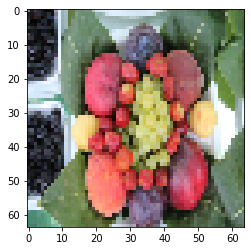

In [16]:
plt.imshow(train_LR[0].permute(1,2,0))
plt.show

리사이즈

In [17]:
print(train_HR[3].shape)
print(train_LR[3].shape)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


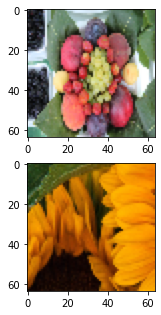

In [18]:
fig ,ax=plt.subplots(2,1,figsize=(5,8))
ax = plt.subplot(3,1,1)
ax.imshow(train_LR[0].permute(1,2,0))

ax = plt.subplot(3,1,2)
ax.imshow(train_HR[0].permute(1,2,0))

fig.show()

In [19]:
data_loader = DataLoader(train_LR, batch_size=128)

In [20]:
for dat in data_loader:
  print(dat.shape)
  break

torch.Size([128, 3, 64, 64])


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    cuda =True

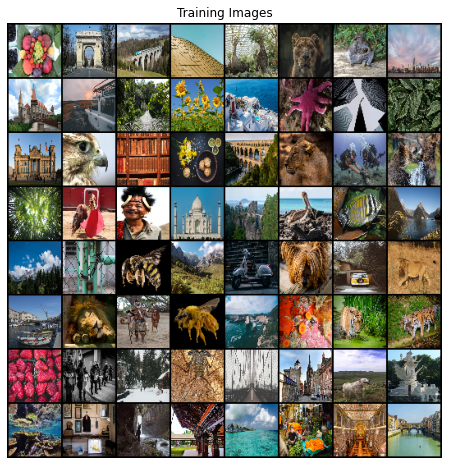

In [23]:
import torchvision.utils as vutils
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

dataset for pytorch srgan

In [24]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [25]:
import glob, itertools
dataset_path ='/content/DIV2K/DIV2K_train_HR'
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True)

모델.

In [26]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])#vgg 의 레이어 17까지.

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super().__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        #self.layers = _get_clones(decoder_layer, num_layers)
        #def _get_clones(module, N):
        #    return ModuleList([copy.deepcopy(module) for i in range(N)])

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [27]:
load_pretrained_models = False

generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if not os.path.exists('/content/input/single-image-super-resolution-gan-srgan-pytorch/saved_models'):
    os.makedirs('/content/input/single-image-super-resolution-gan-srgan-pytorch/saved_models')
if not os.path.exists('/content/input/single-image-super-resolution-gan-srgan-pytorch/images')
    os.makedirs('/content/input/single-image-super-resolution-gan-srgan-pytorch/images')
if load_pretrained_models:
    generator.load_state_dict(torch.load("/content/input/single-image-super-resolution-gan-srgan-pytorch/saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("/content/input/single-image-super-resolution-gan-srgan-pytorch/saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [100]:
n_epochs = 200

In [101]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))
        
        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"/content/input/single-image-super-resolution-gan-srgan-pytorch/images/{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))
    
    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "/content/input/single-image-super-resolution-gan-srgan-pytorch/saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "/content/input/single-image-super-resolution-gan-srgan-pytorch/saved_models/discriminator.pth")

Training Epoch 0 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 2 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 3 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 4 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 5 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 6 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 7 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 8 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 9 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 10 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 11 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 12 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 13 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 14 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 15 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 15 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 16 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 16 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 17 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 17 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 18 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 18 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 19 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 19 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 20 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 20 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 21 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 21 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 22 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 22 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 23 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 23 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 24 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 24 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 25 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 25 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 26 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 26 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 27 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 28 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 29 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 30 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 31 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 32 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 33 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 34 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 35 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 36 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 37 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 38 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 39 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 40 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 41 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 42 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 43 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 44 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 45 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 46 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 47 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 48 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 49 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 50 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 51 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 52 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 53 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 54 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 55 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 56 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 57 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 58 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 59 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 60 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 60 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 61 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 61 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 62 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 62 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 63 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 63 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 64 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 64 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 65 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 65 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 66 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 66 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 67 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 67 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 68 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 68 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 69 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 69 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 70 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 70 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 71 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 71 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 72 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 72 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 73 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 73 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 74 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 74 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 75 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 75 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 76 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 76 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 77 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 77 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 78 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 78 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 79 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 79 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 80 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 80 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 81 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 81 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 82 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 82 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 83 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 83 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 84 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 84 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 85 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 85 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 86 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 86 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 87 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 87 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 88 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 88 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 89 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 89 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 90 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 90 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 91 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 91 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 92 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 92 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 93 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 93 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 94 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 94 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 95 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 95 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 96 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 96 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 97 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 97 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 98 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 98 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 99 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 99 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 100 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 100 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 101 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 101 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 102 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 102 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 103 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 103 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 104 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 104 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 105 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 105 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 106 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 106 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 107 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 107 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 108 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 108 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 109 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 109 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 110 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 110 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 111 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 111 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 112 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 112 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 113 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 113 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 114 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 114 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 115 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 115 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 116 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 116 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 117 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 117 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 118 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 118 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 119 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 119 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 120 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 120 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 121 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 121 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 122 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 122 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 123 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 123 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 124 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 124 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 125 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 125 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 126 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 126 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 127 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 127 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 128 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 128 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 129 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 129 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 130 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 130 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 131 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 131 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 132 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 132 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 133 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 133 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 134 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 134 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 135 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 135 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 136 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 136 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 137 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 137 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 138 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 138 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 139 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 139 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 140 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 140 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 141 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 141 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 142 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 142 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 143 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 143 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 144 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 144 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 145 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 145 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 146 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 146 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 147 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 147 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 148 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 148 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 149 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 149 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 150 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 150 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 151 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 151 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 152 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 152 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 153 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 153 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 154 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 154 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 155 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 155 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 156 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 156 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 157 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 157 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 158 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 158 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 159 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 159 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 160 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 160 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 161 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 161 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 162 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 162 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 163 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 163 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 164 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 164 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 165 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 165 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 166 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 166 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 167 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 167 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 168 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 168 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 169 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 169 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 170 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 170 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 171 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 171 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 172 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 172 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 173 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 173 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 174 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 174 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 175 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 175 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 176 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 176 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 177 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 177 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 178 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 178 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 179 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 179 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 180 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 180 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 181 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 181 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 182 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 182 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 183 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 183 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 184 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 184 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 185 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 185 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 186 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 186 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 187 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 187 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 188 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 188 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 189 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 189 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 190 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 190 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 191 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 191 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 192 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 192 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 193 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 193 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 194 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 194 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 195 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 195 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 196 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 196 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 197 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 197 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 198 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 198 :   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 199 :   0%|          | 0/49 [00:00<?, ?it/s]

Testing Epoch 199 :   0%|          | 0/2 [00:00<?, ?it/s]

In [102]:
!cp /content/input/single-image-super-resolution-gan-srgan-pytorch /content/drive/MyDrive/colabdata/aiffel/ex_onesix/data

cp: -r not specified; omitting directory '/content/input/single-image-super-resolution-gan-srgan-pytorch'


In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [104]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

10 epoches before

프로젝트 1-1

In [105]:
hr_transform_pil = transforms.Compose(
            [   
                transforms.Resize((hr_height, hr_height), Image.BICUBIC)
            ]
        )

In [105]:
generator.eval()

In [106]:
data = next(iter(test_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


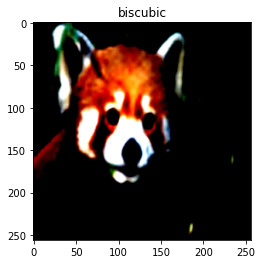

In [107]:
plt.title('biscubic')
img = plt.imshow(transforms.Resize((hr_height, hr_height), Image.BICUBIC)(data['lr'][0]).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


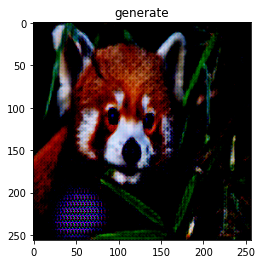

In [115]:
plt.title('generate')
plt.imshow(generator(data['lr'][0].unsqueeze(0).to(device)).detach().cpu()[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


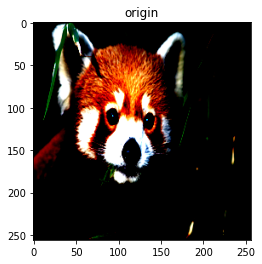

In [109]:
plt.title('origin')
plt.imshow(data['hr'][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


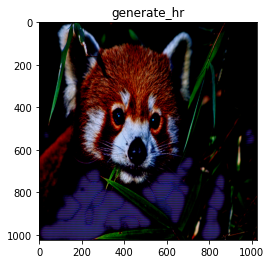

In [184]:
plt.title('generate_hr')
generator.eval()
plt.imshow(generator(data['hr'][0].unsqueeze(0).to(device)).detach().cpu()[0].permute(1,2,0))

프로젝트 1-2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


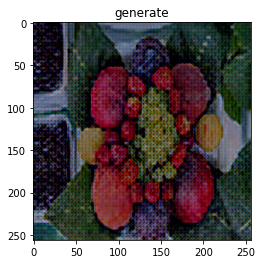

In [161]:
plt.title('generate')
plt.imshow(generator(train_LR[0].unsqueeze(0).to(device)).detach().cpu()[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


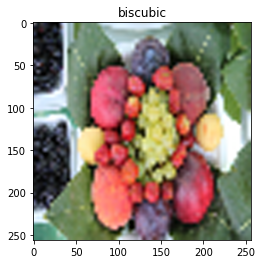

In [111]:
plt.title('biscubic')
plt.imshow(transforms.Resize((hr_height, hr_height), Image.BICUBIC)(train_LR[0]).permute(1,2,0))

In [112]:
!cp /content/drive/MyDrive/colabdata/aiffel/ex_onesix/city_night_lr.gif /content

In [113]:
gif = cv2.VideoCapture("/content/city_night_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


In [114]:
hr_transform_pil = transforms.Compose(
            [   transforms.ToTensor(),
                transforms.Resize((hr_height, hr_height), Image.BICUBIC)
            ]
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


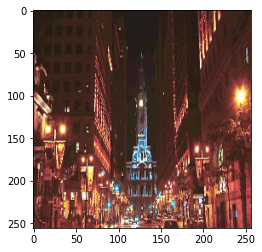

In [125]:
plt.imshow(hr_transform_pil(frames[0]).permute(1,2,0))

In [160]:
tensor_frames =torch.stack([hr_transform_pil(x) for x in frames])

In [144]:
tensor_frames.shape

torch.Size([8, 3, 256, 256])

In [153]:
for x in tensor_frames:
  print(x.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [171]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache>

In [198]:
#gen_frames = [generator(x.unsqueeze(0).type(Tensor)).detach().cpu() for x in tensor_frames]

In [224]:
gen_frames = [generator(x.unsqueeze(0).to(device)).detach().cpu().squeeze(0).permute(1,2,0).numpy() for x in tensor_frames]

In [225]:
import imageio
imageio.mimsave("/content/고해상도.gif", gen_frames)

In [228]:
double_transform_pil = transforms.Compose(
            [
                transforms.Resize((2*255, 2*500), Image.BICUBIC)
            ]
        )

In [232]:
bis_frames = [double_transform_pil(x).permute(1,2,0).numpy() for x in tensor_frames]

In [234]:
imageio.mimsave("/content/bicubic.gif", bis_frames)

gen 이미지 아직 부족한점이 있고, 사이즈가 1000x1000이다.

![고해상도](https://user-images.githubusercontent.com/25836368/143364484-54b4d23d-4870-46c0-aa88-6d2973f7203a.gif)

bicubic 이미지 

![biscubic](https://user-images.githubusercontent.com/25836368/143364528-50c75730-c095-4025-9dce-bbf1d79a5150.gif)


----------메모리 체크---------------


In [190]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 2.2 GB
Cached:    14.3 GB


In [167]:
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=930ef0bff89123b56a4c106082291f655416934052073cd42e0e22a9f8d5ce48
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [191]:
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

In [206]:
mem_report()

CPU RAM Free: 9.6 GB
GPU 0 ... Mem Free: 33MB / 16160MB | Utilization 100%


In [202]:
#torch.cuda.memory_allocated(ID of the device) #returns you the current GPU memory usage by tensors in bytes for a given device
#	torch.cuda.memory_reserved(ID of the device)

SyntaxError: ignored

tensor([[[[0.1804, 0.1838, 0.1325,  ..., 0.1804, 0.1804, 0.1804],
          [0.1804, 0.1838, 0.1325,  ..., 0.1804, 0.1804, 0.1804],
          [0.1804, 0.1838, 0.1325,  ..., 0.1804, 0.1804, 0.1802],
          ...,
          [0.4192, 0.4162, 0.4165,  ..., 0.4402, 0.2833, 0.6100],
          [0.4121, 0.4117, 0.4166,  ..., 0.4908, 0.3098, 0.6102],
          [0.5052, 0.4114, 0.4196,  ..., 0.5379, 0.4460, 0.5963]],

         [[0.1098, 0.1095, 0.1142,  ..., 0.1098, 0.1098, 0.1098],
          [0.1098, 0.1095, 0.1142,  ..., 0.1098, 0.1098, 0.1098],
          [0.1098, 0.1095, 0.1142,  ..., 0.1098, 0.1098, 0.1095],
          ...,
          [0.2036, 0.1804, 0.1475,  ..., 0.1974, 0.1404, 0.2503],
          [0.1489, 0.1491, 0.1482,  ..., 0.2226, 0.1535, 0.2501],
          [0.1869, 0.2056, 0.2040,  ..., 0.1721, 0.1672, 0.2480]],

         [[0.0902, 0.0911, 0.0771,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0911, 0.0771,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0911, 0.0771,  ..., 0